In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import random

In [27]:
random.seed(3888)

In [28]:
df = pd.read_csv("/Users/ayush/Documents/University/Year 03/Sem 01/DATA3888/Optiver-07/Data/individual_book_train/stock_0.csv")

In [ ]:
def make_features(df: pd.DataFrame) -> pd.DataFrame:
    # 1. mid_price & spread
    df['mid_price'] = (df['bid_price1'] + df['ask_price1']) / 2
    df['spread']    = df['ask_price1'] - df['bid_price1']
    
    # 2. imbalance & book_pressure & microprice
    with np.errstate(divide='ignore', invalid='ignore'):
        num  = df['bid_size1'] - df['ask_size1']
        den  = df['bid_size1'] + df['ask_size1']
        df['imbalance'] = np.where(den > 0, num / den, np.nan)

        num2 = (df['bid_size1'] + df['bid_size2']) - (df['ask_size1'] + df['ask_size2'])
        den2 = df[['bid_size1','bid_size2','ask_size1','ask_size2']].sum(axis=1)
        df['book_pressure'] = np.where(den2 > 0, num2 / den2, np.nan)

        num3 = (df['ask_price1'] * df['bid_size1'] +
                df['bid_price1'] * df['ask_size1'])
        df['microprice'] = np.where(den > 0, num3 / den, np.nan)

    # 3. normalized_spread & L2 OBI
    df['normalized_spread'] = df['spread'] / df['mid_price'].replace(0, np.nan)
    df['OBI_L2'] = np.where(den2 > 0, (df['bid_size1'] + df['bid_size2']) / den2, np.nan)

    # 4. LOB entropy
    sizes = df[['bid_size1','bid_size2','ask_size1','ask_size2']].astype(float).values
    total = sizes.sum(axis=1, keepdims=True)
    p = np.divide(sizes, total, where=total != 0)
    entropy = -np.nansum(np.where(p > 0, p * np.log(p), 0), axis=1)
    df['LOB_entropy'] = entropy
    df['LOB_entropy_normalized'] = entropy / np.log(4)

    # 5. log returns
    df['log_return'] = (
        df.groupby('time_id')['mid_price']
          .transform(lambda x: np.log(x / x.shift(1)))
    )

    # 6. Realized volatility (safe: no leakage)
    df['realized_volatility'] = (
        df.groupby('time_id')['log_return']
          .transform(lambda x: np.sqrt((x.shift(1) ** 2)
                                       .rolling(window=30, min_periods=1).sum()))
    )

    df['rv_future'] = (
        df.groupby('time_id')['realized_volatility'].shift(-30)   
    )

    # 7. Bipower variance (safe: no leakage)
    df['bipower_var'] = (
        df.groupby('time_id')['log_return']
          .transform(lambda x: x.abs().shift(1)
                       .rolling(2, min_periods=1)
                       .apply(lambda r: r[0] * r[1], raw=True)
                       .rolling(30, min_periods=1)
                       .mean())
    )

    # 8. WAP and its log return
    df['wap'] = (
        (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']) /
        (df['bid_size1'] + df['ask_size1']).replace(0, np.nan)
    )
    df['log_wap_return'] = (
        df.groupby('time_id')['wap']
          .transform(lambda x: np.log(x / x.shift(1)))
    )

    # 9. Lag features (safe)
    for col in ['imbalance', 'book_pressure', 'log_return']:
        df[f'{col}_lag1'] = df.groupby('time_id')[col].shift(1)
        df[f'{col}_lag2'] = df.groupby('time_id')[col].shift(2)

    # 10. Rolling stats (safe)
    df['rolling_vol_30'] = (
        df.groupby('time_id')['log_return']
          .transform(lambda x: x.shift(1).rolling(30, min_periods=1).std())
    )
    df['rolling_imbalance_mean_30'] = (
        df.groupby('time_id')['imbalance']
          .transform(lambda x: x.shift(1).rolling(30, min_periods=1).mean())
    )

    df = df.dropna(subset=['rv_future'])   
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    return 

In [30]:
df = make_features(df)

In [31]:
feature_cols = [
    'seconds_in_bucket',        
    'mid_price',
    'spread',
    'imbalance', 'imbalance_lag1', 'imbalance_lag2',
    'book_pressure', 'book_pressure_lag1', 'book_pressure_lag2',
    'microprice',
    'normalized_spread',
    'OBI_L2',
    'LOB_entropy', 'LOB_entropy_normalized',
    'log_return', 'log_return_lag1', 'log_return_lag2',
    'bipower_var',
    'wap', 'log_wap_return',
    'rolling_vol_30',
    'rolling_imbalance_mean_30',
    'realized_volatility'
]
target_col = 'rv_future'

In [32]:
X_full = df[feature_cols].values
y_full = df[target_col].values.reshape(-1, 1)
y_scaled = np.log1p(y_full)

feat_scaler = MinMaxScaler()
X_scaled    = feat_scaler.fit_transform(X_full)

In [33]:
SEQ_LEN = 30
def create_dataset(X, y, seq_len):
    Xs, ys = [], []
    for i in range(len(X) - seq_len):
        Xs.append(X[i : i + seq_len])
        ys.append(y[i + seq_len])
    return np.array(Xs), np.array(ys)

X, y = create_dataset(X_scaled, y_scaled, SEQ_LEN)

In [34]:
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [35]:
n_features = X_train.shape[2]
inputs = keras.Input(shape=(SEQ_LEN, n_features), name="sequence_input")

x = layers.LSTM(64, return_sequences=True)(inputs)
x = layers.LSTM(32)(x)
x = layers.Dense(16, activation='relu')(x)
outputs = layers.Dense(1, activation='linear')(x)

model = keras.Model(inputs, outputs, name="lstm_vol_model")
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "lstm_vol_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequence_input (InputLayer)     │ (None, 30, 23)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 30, 64)         │        22,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,489 (138.63 KB)

 Trainable params: 35,489 (138.63 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=256,
    verbose=1
)

Epoch 1/10
2473/2473 ━━━━━━━━━━━━━━━━━━━━ 75s 30ms/step - loss: 2.6618e-04 - val_loss: 4.8873e-07
Epoch 2/10
2473/2473 ━━━━━━━━━━━━━━━━━━━━ 77s 31ms/step - loss: 8.4856e-07 - val_loss: 8.3910e-07
Epoch 3/10
2473/2473 ━━━━━━━━━━━━━━━━━━━━ 74s 30ms/step - loss: 1.0241e-06 - val_loss: 8.5161e-07
Epoch 4/10
2473/2473 ━━━━━━━━━━━━━━━━━━━━ 73s 30ms/step - loss: 6.6051e-07 - val_loss: 2.0321e-06
Epoch 5/10
2473/2473 ━━━━━━━━━━━━━━━━━━━━ 77s 31ms/step - loss: 4.9203e-07 - val_loss: 2.5492e-07
Epoch 6/10
2473/2473 ━━━━━━━━━━━━━━━━━━━━ 76s 31ms/step - loss: 4.4391e-07 - val_loss: 2.9790e-07
Epoch 7/10
2473/2473 ━━━━━━━━━━━━━━━━━━━━ 76s 31ms/step - loss: 3.8329e-07 - val_loss: 2.6996e-07
Epoch 8/10
2473/2473 ━━━━━━━━━━━━━━━━━━━━ 76s 31ms/step - loss: 3.6677e-07 - val_loss: 2.9490e-07
Epoch 9/10
2473/2473 ━━━━━━━━━━━━━━━━━━━━ 75s 30ms/step - loss: 3.4372e-07 - val_loss: 3.0226e-07
Epoch 10/10
2473/2473 ━━━━━━━━━━━━━━━━━━━━ 76s 31ms/step - loss: 3.2660e-07 - val_loss: 3.1315e-07


In [ ]:
y_log_pred = model.predict(X_test)
y_pred = np.expm1(y_log_pred) 
y_true = np.expm1(y_test) 

In [ ]:
eps = 1e-8
y_true = np.clip(y_true, eps, None)
y_pred = np.clip(y_pred, eps, None)
mse   = mean_squared_error(y_true, y_pred)
rmse  = np.sqrt(mse)
mae   = mean_absolute_error(y_true, y_pred)
ratio = y_true / y_pred
qlike = np.mean(ratio - np.log(ratio) - 1)
dir_acc = np.mean(
    np.sign(y_pred[1:] - y_pred[:-1]) 
  == np.sign(y_true[1:] - y_true[:-1])
)
corr = np.corrcoef(y_true, y_pred)[0,1]

In [ ]:
print(f"MSE               : {mse:.6e}")
print(f"RMSE              : {rmse:.6e}")
print(f"MAE               : {mae:.6e}")
print(f"QLIKE             : {qlike:.6f}")
print(f"Directional Acc.  : {dir_acc:.2%}")
print(f"Pearson Corrcoef  : {corr:.4f}")


MSE               : 3.142081e-07
RMSE              : 5.605427e-04
MAE               : 4.181810e-04
QLIKE             : 0.202234
Directional Acc.  : 33.13%
Pearson Corrcoef  : 0.6761


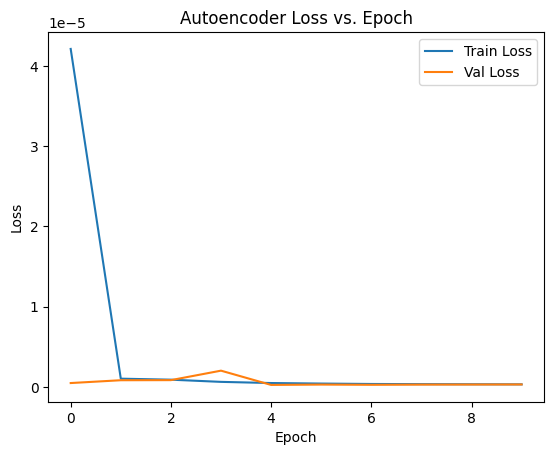

In [38]:
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Autoencoder Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

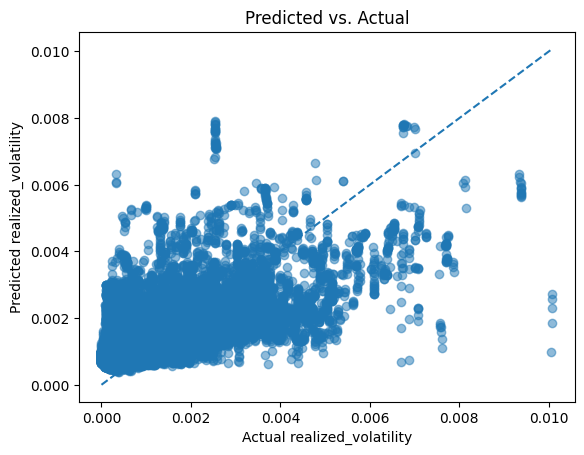

In [39]:
plt.figure()
plt.scatter(y_test, y_pred, alpha=0.5)
plt.title('Predicted vs. Actual')
plt.xlabel('Actual realized_volatility')
plt.ylabel('Predicted realized_volatility')
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, '--')
plt.show()